# Udacity Project: Writing A Data Science Blog Post

## Analyzing the Airbnb dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from datetime import datetime
from helper import *
pd.set_option("max_columns", None)

# 1. Business Understanding


In this notebook, I will focus on answering three business questions using descriptive analysis, inferential statistics, and machine learning:

1. By comparing Boston and Seattle data, can we find any common pattern or attribute that change the listing price? This will help stakeholder to understand earning in certain time frames, areas, etc.

2. What amenities listed on AirBnB can significantly impact on the listing price? This provides tips to host who want to increase their property value.

3. How well can we predict the listing price? This can provide a reference quote to potential hosts who are interested in the business, or any host who want revaluation on their properties.

4. What are key attributes of listings that make AirBnB guest choose one over the other? This will provide tips to newbies ready to start their business, or old hosts struggling to attract more guests to their listings.

# 2. Data Understanding

### 2.1 Load the data

In [2]:
# Combine Boston dataset with the Seattle dataset.
# load boston calendar and listing data
boston_calendar = pd.read_csv('Boston_Airbnb/calendar.csv', delimiter = ',')
boston_calendar['city'] = 'Boston'
boston_list = pd.read_csv('Boston_Airbnb/listings.csv', delimiter = ',')
boston_list['city'] = 'Boston'
boston_list.drop(labels = ['access', 'interaction', 'house_rules'], axis = 1, inplace = True)

In [3]:
# load seattle calendar and listing data
seattle_calendar = pd.read_csv('Seattle_Airbnb/calendar.csv', delimiter = ',',  dtype='unicode')
seattle_calendar['city'] = 'Seattle'
seattle_list = pd.read_csv('Seattle_Airbnb/listings.csv', delimiter = ',',  dtype='unicode')
seattle_list['city'] = 'Seattle'

In [4]:
# merge together
calendar = pd.concat([boston_calendar, seattle_calendar], sort=True).reset_index(drop = True)
calendar['price'] = calendar['price'].apply(parse_dollar)
calendar.date = pd.to_datetime(calendar.date)
calendar['day'] = calendar.date.apply(date2day)
listings = pd.concat([boston_list, seattle_list], sort=True).reset_index(drop = True)

In [5]:
# Check the structure of the data after it's loaded.
nrow = listings.shape[0]
ncol = listings.shape[1]
print('The number of rows and columns: {} x {} in Airbnb dataset'.format(nrow, ncol))
listings.head(1) 

The number of rows and columns: 14966 x 106 in Airbnb dataset


,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,medium_url,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,NaN,2,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",2,76,6,6,1,Real Bed,1,1,1,1,0,0,2019-04-15,6 days ago,super_strict_30,Boston,$75.00,United States,US,Fully separate apartment in a two apartment bu...,none,$0.00,2015-07-10,2,t,My wife and I and grown children frequently oc...,NaN,t,4804,f,t,4,Massachusetts,Frank,East Boston,https://a0.muscache.com/im/users/4804/profile_...,90%,within a day,2008-12-03,https://a0.muscache.com/im/users/4804/profile_...,4,https://www.airbnb.com/users/show/4804,"['email', 'phone', 'reviews']",NaN,3781,f,NaN,f,t,NaN,2019-02-22,2019-04-15,42.3652,NaN,https://www.airbnb.com/rooms/3781,-71.0294,Boston,1125,30,1125,1125,NaN,1125,30,30,30,"$2,250.00",HARBORSIDE-Walk to subway,"Mostly quiet ( no loud music, no crowed sidewa...",East Boston,East Boston,NaN,Building is on quiet side of airport. Building...,15,2,https://a0.muscache.com/im/pictures/24670/b2de...,$125.00,Apartment,f,f,f,10,10,10,10,10,99,10,0.33,Entire home/apt,20190415184256,$0.00,"Boston, MA",This is a totally separate apartment located o...,NaN,MA,"Boston, MA, United States",Fully separate apartment in a two apartment bu...,NaN,Local subway stop ( Maverick Station on the Bl...,$750.00,NaN,02128


### 2.2 Check the data range

Once the data is loaded, it is a good idea to check if there is anything abnormal among the numerical columns. The table below shows that the column license is all missing, which can be dropped in the following step of handling the missing values.

In [6]:
listings.describe()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,medium_url,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
count,6045,14966,14966,14966,14966,14966,14966,14957,14966,14959,14961,14966,14966,14966,14966,14966,14966,14966,14966,13225,14966,14966,14887,14966,14966,12531,14966,14966,10754,0.0,14965,14966,14965,14965,14965,14941,14965,13429,14965,12065,12065,14965,14965,14965,14966,14966,6675,14966,14966,6545,14966,14966,8762,12531,14966,14966.000,25,14966,14966.00000,14935,14966,14966,14966,14966,0.0,14966,14966,14966,14966,1373,14965,10413,14966,14966,8764,9034,14966,14966,14966,14966,14966,14966,14966,14966,12399,12395,12400,12403,12396,12405,12397,12531.0,14966,14966,11532,14966,11615,530,14954,14966,14690,0.0,10459,1621,0.0,14822
unique,5047,36,12484,62,731,122,182,25,5,18,35,71,66,32,14,3,73,6,2,227,1,1,12966,1,62,2116,28,1,5199,0.0,2,8047,2,2,128,451,3463,180,8030,58,4,2759,8030,128,8043,291,4994,14966,2,4803,1,2,2,1102,3,10574.000,8,14966,10681.00000,6,259,99,258,359,0.0,259,87,88,315,363,14664,7533,111,112,17,6240,662,277,14610,502,30,2,2,1,18,17,16,16,17,86,16,1642.0,3,2,89,55,9557,92,4,54,12152,0.0,7874,366,0.0,76
top,Guests will have access to the entire apartmen...,2,"{TV,Internet,Wifi,Kitchen,Elevator,Heating,""Fa...",0,0,0,0,1.0,Real Bed,1,1,1,1,0,0,2019-04-15,today,strict_14_with_grace_period,Seattle,$100.00,United States,US,This beautiful modern apartment in the heart o...,none,$0.00,2018-09-03,1,t,We are a passionate team running a modern tech...,NaN,t,8534462,f,f,1,"Seattle, Washington, United States",Corp Condos & Apts,Capitol Hill,https://a0.muscache.com/im/pictures/user/3f3e3...,100%,within an hour,2013-08-30,https://a0.muscache.com/im/pictures/user/3f3e3...,1,https://www.airbnb.com/users/show/8534462,"['email', 'phone', 'reviews', 'kba']",- You agree to the following: - - CHECK-IN: i...,17039358,t,We are available to assist you with absolutely...,f,t,{WASHINGTON},2019-03-31,2019-04-15,42.345,LB-101773,https://www.airbnb.com/rooms/4438871,-71.06109,Seattle,1125,2,1125,1125.0,NaN,1125,1,2,2.0,"$3,000.00",Lux 2 Bedroom by Fenway with washer/dryer & WIFI,Located in central South Lake Union these apar...,Capitol Hill,Broadway,Other neighborhoods,We offer complimentary upgrades to our regular...,0,0,https://a0.muscache.com/im/pictures/f5c14a62-0...,$150.00,Apartment,f,f,f,10,10,10,10,10,100,10,1.0,Entire home/apt,201

### 2.3 Determine What Features to Keep

At first glance, we can drop some of the columns that are not useful for our model. For example, 1. the urls linked to the images; 2. text descriptions such as **notes**, **access**, **interaction** (unless we want to perform sentimental analysis); 3. names such as **host_name**; 4. geolocations such as **zipcode**. We will keep the following features, and will later finalize on the features used in the price and book-rate model.

In [7]:
# only keep the following features in the dataset
cols = ['id', 'host_id', 'host_since', 'last_scraped', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
             'host_is_superhost', \
             'host_identity_verified', 'neighbourhood_cleansed', 'city', 'neighbourhood_group_cleansed', \
             'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', \
             'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', \
             'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', \
             'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', \
             'first_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
             'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'requires_license', \
             'license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', \
             'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']
cleaned_list = listings[cols]

cleaned_list.head(5)

,id,host_id,host_since,last_scraped,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,3781,4804,2008-12-03,2019-04-15,within a day,90%,NaN,t,f,East Boston,Boston,NaN,42.3652,-71.0294,Apartment,Entire home/apt,2,1,1,1,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",NaN,$125.00,$750.00,"$2,250.00",$0.00,$75.00,2,$0.00,30,1125,76,15,2015-07-10,99,10,10,10,10,10,f,NaN,f,super_strict_30,f,f,1,0.33
1,5506,8229,2009-02-19,2019-04-15,within an hour,99%,NaN,t,t,Roxbury,Boston,NaN,42.3298,-71.0956,Guest suite,Entire home/apt,2,1,1,1,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",225,$145.00,$980.00,"$3,000.00",$0.00,$50.00,1,$0.00,3,730,189,84,2009-03-21,95,10,10,10,10,10,f,NaN,t,strict_14_with_grace_period,f,f,6,0.69
2,6695,8229,2009-02-19,2019-04-15,within an hour,99%,NaN,t,t,Roxbury,Boston,NaN,42.3299,-71.0935,Condominium,Entire home/apt,4,1,1,2,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$169.00,NaN,NaN,NaN,$70.00,2,$8.00,3,730,151,86,2009-08-06,97,10,10,10,10,9,f,NaN,t,strict_14_with_grace_period,f,f,6,0.73
3,6976,16701,2009-05-11,2019-04-15,within an hour,100%,NaN,t,t,Roslindale,Boston,NaN,42.2924,-71.1358,Apartment,Private room,2,1,1,1,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",NaN,$65.00,$395.00,"$1,350.00",$0.00,$0.00,1,$30.00,3,60,93,75,2009-07-19,98,10,10,10,10,10,f,NaN,f,moderate,t,f,1,0.63
4,8789,26988,2009-07-22,2019-04-15,within a few hours,89%,NaN,f,f,Downtown,Boston,NaN,42.3592,-71.0627,Apartment,Entire home/apt,2,1,1,1,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$99.00,"$1,200.00","$2,900.00","$1,000.00",$250.00,1,$0.00,28,365,260,22,2014-08-12,92,9,9,10,10,9,f,NaN,f,strict_14_with_grace_period,f,f,9,0.39


### Discussion:

In general, the datset contains the following attributes:

For explanatory variables:

 1. Host's personal information: **host_id**, **host_identity_verified**.

 2. Host's experience: **host_is_superhost**, **calculated_host_listings_count**, **host_since**

 3. Host's readyness to help: **host_response_time**, **host_response_rate**, **host_acceptance_rate**, etc.

 4. Listing's basic information: **id, amenities**, **room_type**, **neighbourhood**, **homestay policy**, etc.

 5. Listing's reviews: **number_of_reviews**, **reviews_per_month**, **review_scores_rating**, etc.

For response variable:

Listing's annualized availability: **availability_365**
Listing's total price: **price** and **cleaning_fee**

**Question 1**: Can we use **number_of_reviews** to measure how popoluar the listing is?

**Answer**: Using **number_of_reviews** can lead to a biased conclusion since **number_of_reviews** is aggregated from the date of **host_since**. Therefore, time development can also contribute to a listing with many reviews!

**Question 2**: Can we use the normalized **reviews_per_month** instead?

**Answer**: Using **availability_365** is better than **reviews_per_month**, in that guests who visited at a listing may not necessarily provide feedback. In later section, we show that about 30% of listings have no guest ratings and reviews.

# 3. Data Preparation: Accessing Missing Data

### 3.1 Accessing Missing Data in Each Column

The list belows show the percentage of missing values for each column, sorted in descending order. The columns having 100% missing value, **host_acceptance_rate**, **license**, can be discarded. Unfortunately, the area of the house, **square_feet**, contains 96% of missing value, rendering it worthless to keep. Both **monthly_price** and **weekly_price** can be dropped since they are another measure of **price**. Although **security_deposit** contains more than 23% of missing values, which can be parsed from string to number (np.nan can be assumed to be 0, "no deposit required"). Similarly, we can parse **cleaning fee** and **price**. For the rest of columns with less than 20% of missing values, we can apply imputation method below.

host_acceptance_rate            1.000000
license                         0.998330
square_feet                     0.964586
monthly_price                   0.908259
weekly_price                    0.891688
neighbourhood_group_cleansed    0.414406
security_deposit                0.229453
host_response_time              0.193839
host_response_rate              0.193839
review_scores_checkin           0.171789
dtype: float64

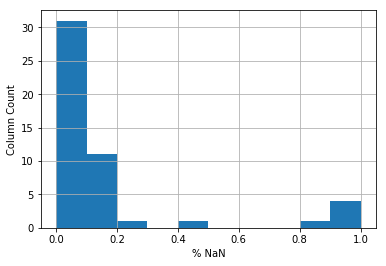

In [8]:
nan_cols = (cleaned_list.isnull().sum()/cleaned_list.shape[0]).sort_values(ascending = False)
ax = nan_cols.hist()  
ax.set_xlabel("% NaN")
ax.set_ylabel("Column Count")
nan_cols.head(n=10)

In [9]:
# drop high-NaN columns
cleaned_list = cleaned_list.drop(labels = ['host_acceptance_rate','license', 'square_feet', 'monthly_price', 'weekly_price', \
                                           'neighbourhood_group_cleansed', 'security_deposit'], axis = 1)

### Formatting Issue

After shrinking our features into a manageable scale, we can now check the formating in each column. Dollar such as **cleaning_fee**, **price**, **extra_people**, and percentage such as **host_response_rate** should be converted to numeric columns. Also notice that the column amenities contains a long list of **amentities**, which will be handled later in feature engineering step. Finally, date in string should be parsed to date_time object.

In [10]:
# formatting from string to the correct format
cleaned_list['cleaning_fee'] = cleaned_list['cleaning_fee'].apply(parse_dollar)
cleaned_list['price'] = cleaned_list['price'].apply(parse_dollar)
cleaned_list['extra_people'] = cleaned_list['extra_people'].apply(parse_dollar)
cleaned_list['host_response_rate'] = cleaned_list['host_response_rate'].apply(parse_percentage)
cleaned_list['last_scraped'] = pd.to_datetime(cleaned_list['last_scraped'])
cleaned_list['host_since'] = pd.to_datetime(cleaned_list['host_since'])

### 3.2 Accessing Missing Data in Each Row

The distribution of missing values for each row below shows that the majority of row entries (listed apartment) is concentrated on the 0% bin, while there are some outliers near or above 20% bin.

Text(0, 0.5, 'Row Count')

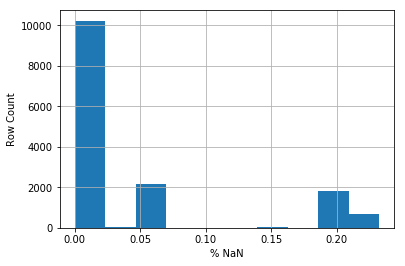

In [11]:
# create a column to flag if the row contain any NaN value
cleaned_list['has_NaN'] = (cleaned_list.isnull().sum(axis = 1)/cleaned_list.shape[1]) > 0
# plot NaN distribution
nan_rows = (cleaned_list.isnull().sum(axis = 1)/cleaned_list.shape[1]).sort_values(ascending = False)
ax = nan_rows.hist()
ax.set_xlabel("% NaN")
ax.set_ylabel("Row Count")

In [12]:
# drop data containing any missing values
dropped_list = cleaned_list.iloc[nan_rows[(nan_rows==0)].index.tolist(), :].reset_index(drop = True)
nan_list = cleaned_list.iloc[nan_rows[(nan_rows>0)].index.tolist(), :].reset_index(drop = True)
print("All data with any missing value has been dropped, which consists of {}% of total population."\
      .format(nan_list.shape[0]*100/(dropped_list.shape[0]+nan_list.shape[0])))

All data with any missing value has been dropped, which consists of 31.651743952960043% of total population.


To understand what these data might represent, we can explore the top missing-value rows, as shown in below:

In [13]:
cleaned_list.iloc[nan_rows.index.tolist(), :].head(10) 

,id,host_id,host_since,last_scraped,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,has_NaN
3307,21623921,76474966,2016-06-08,2019-04-15,NaN,NaN,f,f,Roxbury,Boston,42.3187,-71.0788,House,Entire home/apt,6,2.5,3,3,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",160.0,40.0,1,0.0,4,20,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN,True
3993,23624928,85285560,2016-07-22,2019-04-15,NaN,NaN,f,f,Jamaica Plain,Boston,42.3107,-71.1193,House,Private room,1,1,1,1,Real Bed,"{Wifi,Kitchen,Breakfast,Heating,Washer,Dryer,""...",75.0,0.0,1,0.0,1,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True
6152,33769694,254565168,2019-04-10,2019-04-15,NaN,NaN,f,f,Mission Hill,Boston,42.3357,-71.0974,House,Shared room,1,1.5,1,1,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Hot tub"",...",40.0,0.0,1,0.0,25,29,322,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,t,flexible,f,f,1,NaN,True
6150,33749105,254203610,2019-04-08,2019-04-15,NaN,NaN,f,f,East Boston,Boston,42.3965,-70.989,Apartment,Entire home/apt,5,1,2,2,Real Bed,"{TV,Wifi,Kitchen,Heating,""Smoke detector"",""Car...",190.0,95.0,5,50.0,1,1125,84,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True
634,5684346,18494756,2014-07-20,2019-04-15,NaN,NaN,f,t,Fenway,Boston,42.3431,-71.0884,Apartment,Entire home/apt,3,1,1,2,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Doorman,El...",155.0,0.0,1,0.0,1,1125,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True
2540,18772750,130633148,2017-05-16,2019-04-15,NaN,NaN,f,f,Allston,Boston,42.352,-71.131,Apartment,Private room,2,1,2,2,Real Bed,"{Wifi,Kitchen,Heating,Washer,Dryer,""Smoke dete...",50.0,0.0,1,0.0,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,t,flexible,f,f,1,NaN,True
645,5729203,29690250,2015-03-20,2019-04-15,NaN,NaN,f,t,Dorchester,Boston,42.2927,-71.0724,House,Private room,1,1,1,1,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",75.0,0.0,1,0.0,7,1125,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True
646,5738018,7302835,2013-07-05,2019-04-15,NaN,NaN,f,t,Jamaica Plain,Boston,42.325,-71.1055,Apartment,Entire home/apt,4,1,2,1,Real Bed,"{Wifi,Kitchen,""Pets allowed"",Heating,""Family/k...",95.0,0.0,1,0.0,5,1125,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True
6143,33719182,190085603,2018-05-17,2019-04-15,NaN,NaN,f,f,Allston,Boston,42.3539,-71.134,Condominium,Private room,1,1,1,0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,""Hot tub"",Hea...",36.0,0.0,1,0.0,30,75,85,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True
6142,33718681,253840197,2019-04-07,2019-04-15,NaN,NaN,f,f,Allston,Boston,42.367,-71.1133,Apartment,Entire home/apt,4,1,1,1,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",175.0,50.0,2,30.0,1,14,171,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN,True


The table above shows the NaN data in more detail: many corresponds to the new hosts who have just entered into business (e.g. 4th row: host_since in 2015) or old hosts who has only a few times of calculated_host_listings_count (mostly only one time). Therefore, they received no guest ratings at all ("0" in number_of_reviews, "nan" in first review, review_scores_rating and host_response_time, etc).

We can plot the distribution of the two groups, with/without reviews, to validate whether these high-NaN data represents a new group of hosts distinct from the majority. It can be justified by the two examples below that both groups share very similar distribution with respect to response variables avalability_365 and price. In other words, they represent the same group. Therefore, we can proceed to apply imputation towards the high-NaN data with its mode for each column.

In [14]:
#pd.DataFrame(cleaned_list).to_excel('output.xlsx',header=True, index=False)

In [15]:
# impute missing values with the most frequent value in the column
impute_cols = cleaned_list.columns[cleaned_list.isnull().any()]
for col in impute_cols:
    impute_mode(cleaned_list, col)

# 4. Exploratory Data Analysis

### 4.1 Identify Patterns in Time-Series Data


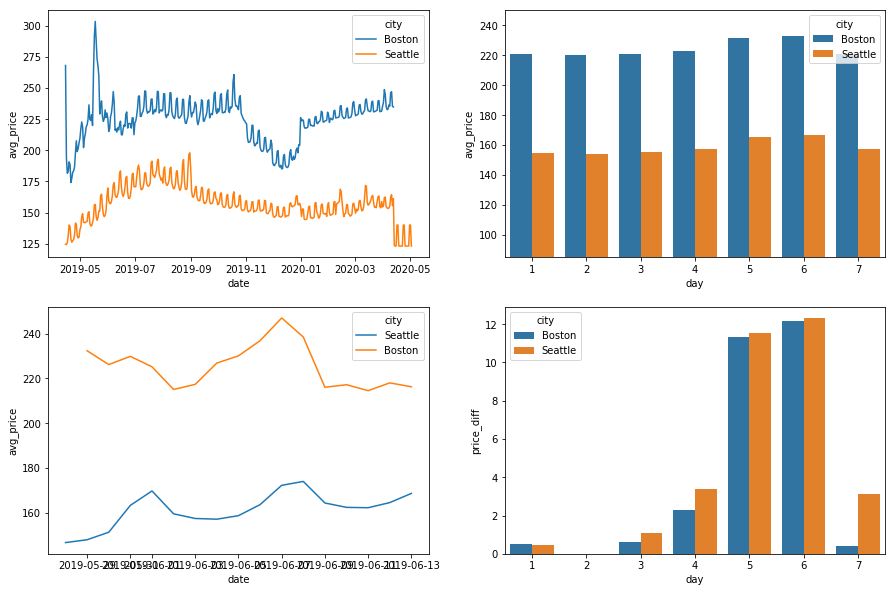

In [16]:
# explore time-series pricing data
ax, [avg_price, boston_day_factor, seattle_day_factor, day_factor] = plot_timeseries_price(calendar)

### Discussion

Figure on the top left panel shows an overview of the time-series average listing price in Boston (Orange) and Seattle (Blue). Both prices in Boston and Seattle show an interesting jigsaw pattern in all time. The bottom left panel shows a particular time window in more details. The pattern is periodic and typically peaks near the weekends. The right panels show the price aggregated on days. In general, rates on Friday and Saturday are around \~$230 in Boston, ~\$10 higher than the Tuesday's rate; daily rate in Seattle is always a $70 cheaper than Boston, but rates on Friday and Saturday boost up by ~\$5, which change more significantly than Boston.

From the result above, I obtain the daily rate factor, and will include it into the listing price model.

### 4.2 Price versus Other Important Features

**Overview:**

The following shows a few examples of features that leads to price variation. These features includes, but not limited to: **neighbourhood**, **number of bedrooms**, **room type**, and **number of guests**. Based on these findings, I will select these notable features into the model.

#### 4.2.1 Listing Neighbourhood

Boston Price Ranged From 76 to 859, average: 212
Seattle Price Ranged From 62 to 467, average: 143


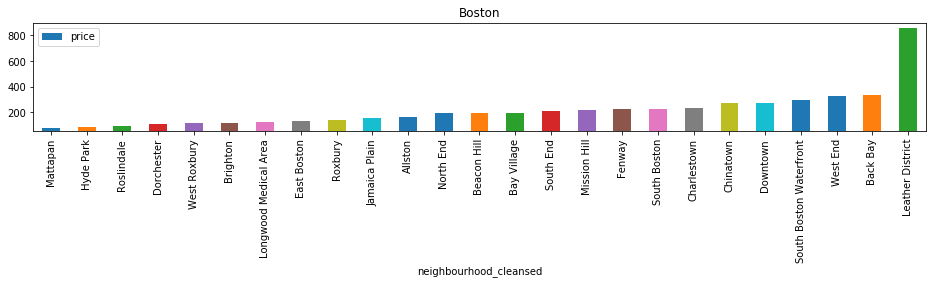

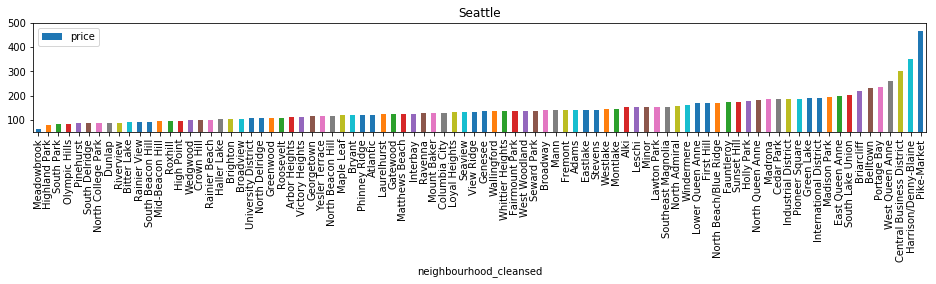

In [17]:
plot_dist(cleaned_list, x = 'neighbourhood_cleansed', y = 'price', split = True, figsize = (16, 2))

#### 4.2.2  Number of Bedroom

Boston Price Ranged From 135 to 1960, average: 555
Seattle Price Ranged From 129 to 1150, average: 424


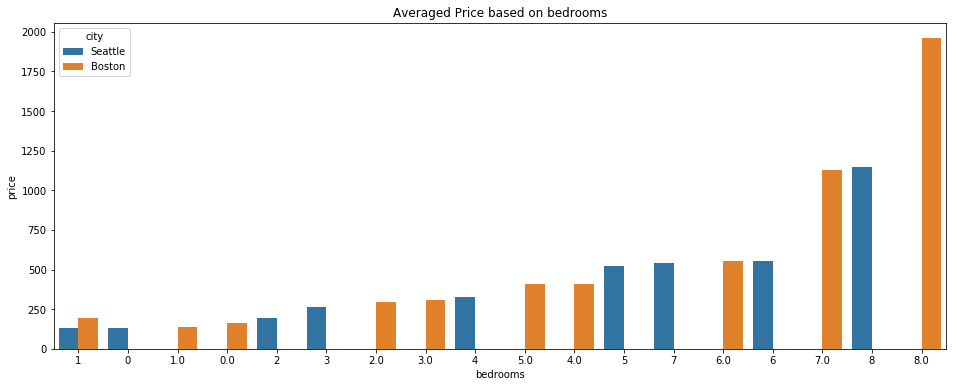

In [18]:
plot_dist(cleaned_list, x = 'bedrooms', y = 'price', split = False, figsize = (16, 6))

Boston Price Ranged From 135 to 1960, average: 555
Seattle Price Ranged From 129 to 1150, average: 424


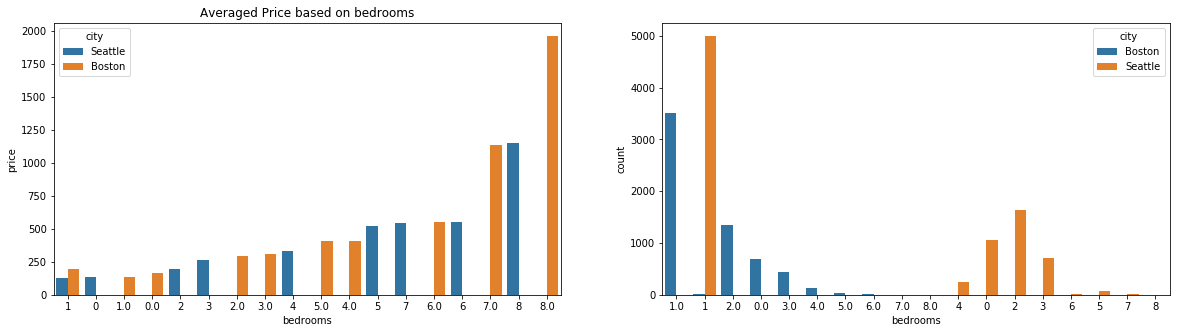

In [19]:
figsize = (20, 5)
x = 'bedrooms'
fig = plt.figure(figsize = figsize)
ax = plot_dist(cleaned_list, x = x, y = 'price', fig = fig, nrows = 1, ncols = 2, split = False)
fig = ax.get_figure()
fig.add_subplot(1, 2, 2)
count_plot(cleaned_list, feature = x, hue = 'city', ax = ax, normalized = False)

#### 4.2.3 Room Type

Boston Price Ranged From 62 to 253, average: 133
Seattle Price Ranged From 49 to 193, average: 106


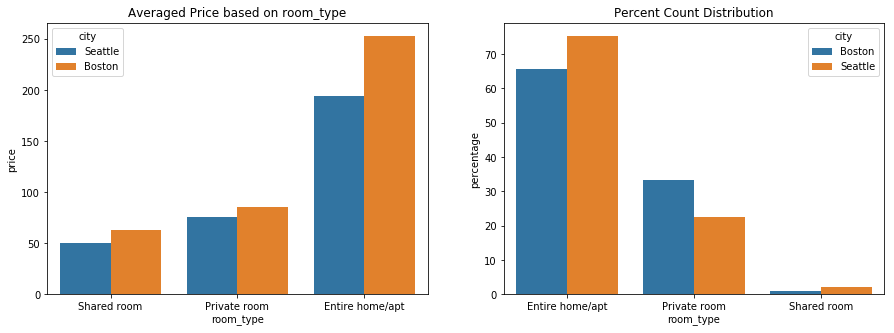

In [20]:
figsize = (15, 5)
x = 'room_type'
fig = plt.figure(figsize = figsize)
ax = plot_dist(cleaned_list, x = x, y = 'price', fig = fig, nrows = 1, ncols = 2, split = False)
fig = ax.get_figure()
fig.add_subplot(1, 2, 2)
count_plot(cleaned_list, feature = x, hue = 'city', ax = ax, normalized = True)

#### 4.2.4 Number of Guests

Boston Price Ranged From 72 to 893, average: 395
Seattle Price Ranged From 64 to 650, average: 380


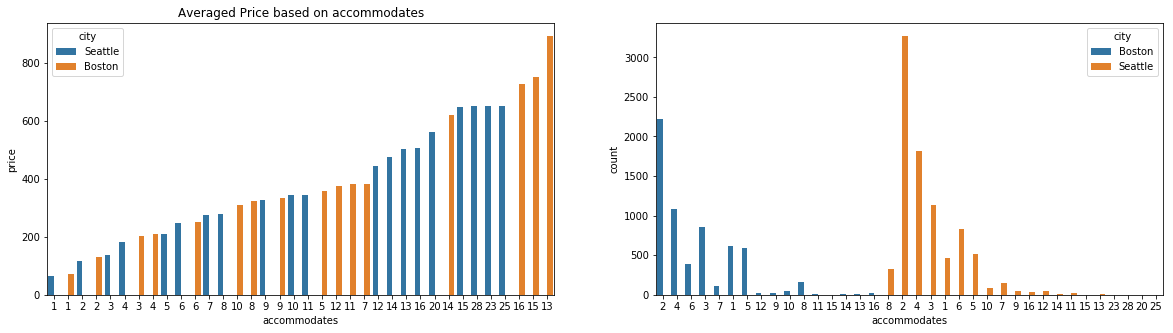

In [21]:
figsize = (20,5)
x = 'accommodates'
fig = plt.figure(figsize = figsize)
ax = plot_dist(cleaned_list, x = x, y = 'price', fig = fig, nrows = 1, ncols = 2, split = False)
fig = ax.get_figure()
fig.add_subplot(1, 2, 2)
count_plot(cleaned_list, feature = x, hue = 'city', ax = ax, normalized = False)

### Discussion

From the results above, we find that the listing price varies by:

1. **Neighbourhood**: The highest price is **Leather District, Boston** ($859), whereas the lowest price ($62) is **Medow Brook, Seattle**. The average price in Boston is \$212, compared to Seattle \$143.
2. **Room type**: The entire apartment is of course most expensive: \$253 in Boston, and \$192 in Seattle. The most economic option is shared room: \$62 in Boston, \$49 in Seattle.
3. **Number of bedrooms**: Price also scales up with the number of bedrooms. Both Boston and Seattle share similar distribution of bedrooms, where one-bedroom listings dominate over others.
4. **number of guests**: Similar to bedrooms, the more guests check in, the high the price is charged. But most hosts in both Boston and Seattle only allow 2 guests at max.

Other similar factors (not complete):

5. **Number of beds**
6. **bed_type**
7. **Number of amenities**
8. **minimum nights**

# 5. Data Modeling and Evaluation

## 5.1 Engineer Features

Feature engineering is very important in machine learning, and it's also the most time consuming part. In this section, I will perform two tasks: generate new features from the dataset column, and encode non-numerical columns in order to run the machine learning algorithm.

#### 5.1.1 Decide what new feature can be generated from the dataset, and which feature to be used in the model

For the book rate model, the response variable is the **availibaility_365**, the total number of day available in one year. Instead, I prefer to use the book rate to quantify how popular the listing is. The book rate can simply converted by: 1-**availibaility_365**/365.

For the pricing model, the response variable is the sum of **price** and **cleaning_fee**, since this is the actual amount paid by the guest.

Recall that we calculated the daily rate factor in Section 4.1, which responds to the feature named **day_factor**. 

Finally, we can discard some other attributes, such the lattitude, longitude, date, id, etc.

In [22]:
# convert the availability to booking rate
cleaned_list['booked_365'] = cleaned_list['availability_365'].apply(lambda x: (365 - int(x)/365*100))
# calculate the day difference based the two dates: host_since and last_scrape
day_diff(cleaned_list)
# convert date to day
cleaned_list['day'] = cleaned_list.last_scraped.apply(date2day)
# create a day factor feature based on the date
cleaned_list = cleaned_list.reset_index().set_index('day').join(day_factor) \
                .sort_values(by='index').set_index('index')
# drop unnecessary columns in modeling the host booking rate
feature_to_drop = ['id', 'host_id', 'latitude', 'longitude', 'city', \
                   'host_since', 'last_scraped', 'first_review', 'requires_license', 'availability_365', 'has_NaN']
processed_list = cleaned_list.drop(labels = feature_to_drop, axis = 1)

#### 5.1.2 Engineer Ordinal Features

In [23]:
processed_list.host_response_time = processed_list.host_response_time.apply(engineer_host_response_time)
processed_list.cancellation_policy = processed_list.cancellation_policy.apply(engineer_cancellation_policy)

#### 5.1.3 Re-Encode Binary Categorical Features

In [24]:
processed_list.host_is_superhost = processed_list.host_is_superhost.apply(encode_binary)
processed_list.host_identity_verified = processed_list.host_identity_verified.apply(encode_binary)
processed_list.instant_bookable = processed_list.instant_bookable.apply(encode_binary)
processed_list.require_guest_profile_picture = processed_list.require_guest_profile_picture.apply(encode_binary)
processed_list.require_guest_phone_verification = processed_list.require_guest_phone_verification.apply(encode_binary)

#### 5.1.4 Re-Encode Multi-Class Categorical Features

In [25]:
cat_features = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']
processed_list = pd.get_dummies(data = processed_list, columns = cat_features)

#### 5.1.5 Engineer Mixed-Type Features

**amenities** consists of a long list of amenities in string format. To fully utilize this column, I can split the list into a set of amentities. From there, they can be endcoded into categorical dummy variables. I can also calculate the total count of amenties, **Total_Amenities** as my feature.

In [26]:
# iterate over each amenity and add its categorical dummy variable to the dataframe
listing_amenity = process_amenity(processed_list)
amenity_cat = set(listing_amenity.keys())
amenity_cat.remove('')
amenity_cols = []
for item in amenity_cat:
    amenity_cols.append(item)
    add_new_amenity(processed_list, listing_amenity, item)

In [27]:
# count the number of listings for each type of amenities
amenity_pct = processed_list[amenity_cols].sum(axis = 0).sort_values(ascending = True)/processed_list.shape[0]*100
amenity_pct = amenity_pct.reset_index()
amenity_pct.rename(columns = {'index': 'amenity', 0: 'PCT'}, inplace = True)

# calculate the price difference between the listing w specific amenity and listing w/o amenity
am_price = pd.DataFrame(data= np.zeros((len(amenity_cols), 2)), 
                        index = amenity_cols, columns = ['price_wo_amenity', 'price_w_amenity'])
for col in amenity_cols:
    price_wo_amenity = processed_list[processed_list[col] == 0]['price'].mean()
    price_w_amenity = processed_list[processed_list[col] == 1]['price'].mean()
    am_price.loc[col,'price_wo_amenity'] = price_wo_amenity
    am_price.loc[col,'price_w_amenity'] = price_w_amenity
    am_price.loc[col,'price_difference'] = price_w_amenity - price_wo_amenity
    am_price.loc[col,'%price_difference'] = (price_w_amenity - price_wo_amenity)/price_wo_amenity
    am_price.loc[col,'%price_abs_difference'] = np.abs((price_w_amenity - price_wo_amenity)/price_wo_amenity)
am_price = am_price.sort_values(by='%price_abs_difference', ascending = True)

# calculate the total number of amenities, store it into a new column
processed_list['Total_Amenities'] = processed_list.amenities.apply(lambda x: x.count(',')-1 )
processed_list = processed_list.drop(labels = 'amenities', axis = 1)

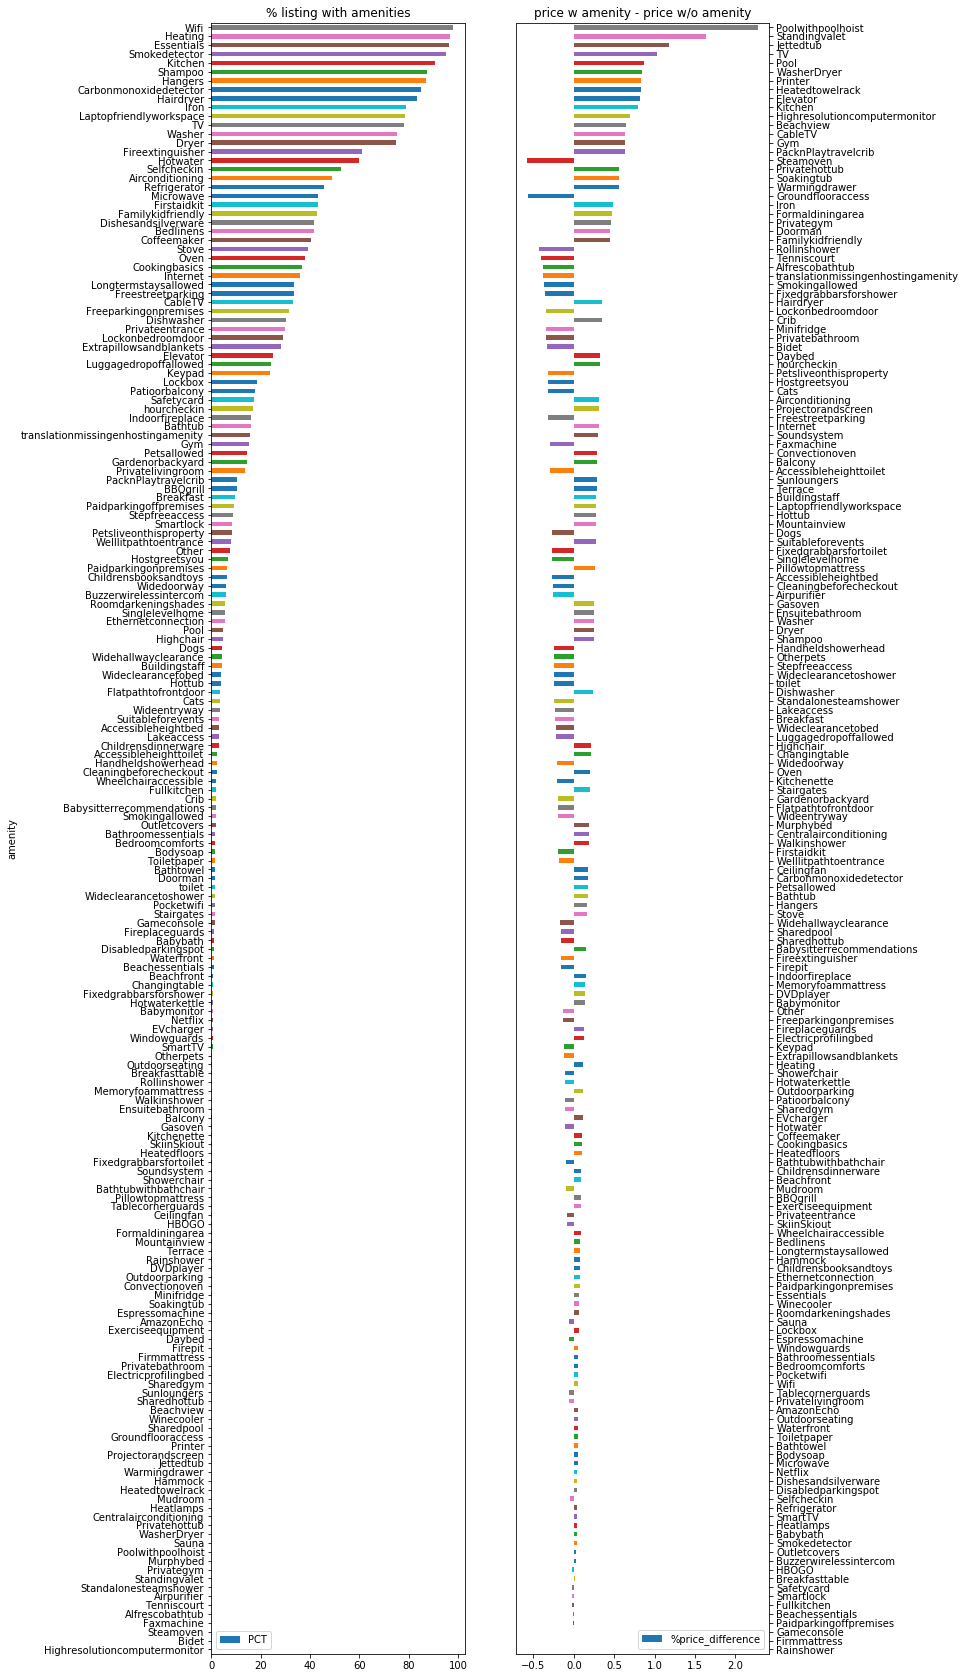

In [28]:
# plot the distribution of amenity type, and the price difference
figsize = (10, 30)
fig = plt.figure(figsize = figsize)
ax = fig.add_subplot(1, 2, 1) 
ax = amenity_pct.plot.barh(x='amenity', y='PCT', ax =ax, title = '% listing with amenities')
#fig = ax.get_figure()
ax = fig.add_subplot(1, 2, 2) 
ax = am_price.plot.barh(y = '%price_difference', ax = ax, title = 'price w amenity - price w/o amenity')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

In [29]:
processed_list.head(5)

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,booked_365,host_days,day_factor,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North End,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Rainier View,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South Delridge,neighbourhood_cleansed_South End,neighbourhood_cleansed_South Lake Union,neighbourhood_cleansed_South Park,neighbourhood_cleansed_Southeast Magnolia,neighbourhood_cleansed_Stevens,neighbourhood_c

### Discussion

The amenity-type distribution (left panel) shows that the top 3 common amenities among the listings are Wifi, Heating, and Essentials, with very few listings with Netflix, smartTV, Windowguards, etc. On the one hand, by comparing the average price difference between the listing with a particular amenity and those without, we can see that amenities such as Poolwithpollhoist, standingvalet, jettedtub  add significant values to the homestay (We need to be careful with very popular/rare amenties, such as WasherDryer, since either the listings with or without these amenities may not accumlate enough statistics to make an inference). On the other hand, we can also see that pets and smoke friendly significantly depreciate the listing value.

In modeling the listing price, I will select amenities that significantly add/reduce the listing price as part of features.

## 5.2 Listing-Price Model

#### 5.2.1 Build and Train the Model

In [30]:
# combine price and cleaning fee to total price
data = processed_list.copy()
data['total_price'] = data['price']  + data['cleaning_fee']
# drop unwanted features
drop_cols = ['price', 'cleaning_fee', 'calculated_host_listings_count', 'host_days', 'cancellation_policy']
data.drop(labels = drop_cols, axis = 1, inplace = True)
# drop unwanted amenity dummy variables
amenity_keep_cols = ['WasherDryer', 'Doorman', 'TV', 'AirConditioning', 'FamilyKidFriendly', 'Kitchen',
                     'CableTV', 'Dryer', 'Washer', 'HairDryer'] 
amenity_drop_cols = []
for col in amenity_cols:
    if col not in amenity_keep_cols:
        amenity_drop_cols.append(col)
data.drop(labels = amenity_drop_cols, axis = 1, inplace = True)
## apply feature scaling
scaler = StandardScaler()
data_transformed = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)
X_transformed = data_transformed.drop(labels = ['total_price'], axis = 1)
y_transformed = data_transformed[['total_price']].iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state = 42)

# specify 'GB' to use gradient-boost regressor, or 'RF' random forest regressor
method = 'GB'
criterion = ['mse']
# After trying different parameter sets, 
# I found the gradient-boosting regressor performs the best with the following parameters.
# Random forest regressor can easily yield to overfitting.
# Feel free to try different parameters. 
n_estimators = [4000]
max_features = [10]
max_depth = [6]
min_samples_leaf = [2]
# lower learning rate prevents overfitting
learning_rate = 0.001 
# number of fold in the training
cv = 5

best_clf = GridSearch(X_train, X_test, y_train, y_test, method = method, learning_rate = learning_rate, \
                      criterion = criterion, n_estimators = n_estimators, validate = True, cv = cv, \
                      max_features = max_features, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

y_pred = best_clf.predict(X_test)

r_squared = r2_score(y_test, y_pred)
root_mse = np.sqrt(mean_squared_error(y_test, y_pred))
importances = best_clf.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})

C:\Users\Choty\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Choty\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


The training MSE Score is 0.3354828940214166
The training R2 Score is 0.6894154727409947
The testing MSE Score is 0.22386221527236794
The testing R2 Score is 0.7244083633932146


In [31]:
# perform k-fold cross-validation
scorer = make_scorer(r2_score)
clf_scores = cross_val_score(best_clf, X_test, y_test,
                             scoring= scorer, cv=10)
print('The average R2 score on the test set: ', clf_scores.mean())

The average R2 score on the test set:  0.7152960586955669


### Discussion

I have compared two ensemble algorithms, the random forest and gradient boost regressor. On the one hand, the random forest often overfits on the training data even if I tried a larger number of trees, while reducing the maximum features and tree depth. On the other, the overfitting issues can be addressed by choosing a small learning rate using the gradient boost regressor, while pertaining good accuracies on both training and testing. After cross-validation above, the R-square on the test set has been slighly improved, close to R-square on the train set, with an accuracy around 72%.

#### 5.2.1 Evaluate the Feature Importance

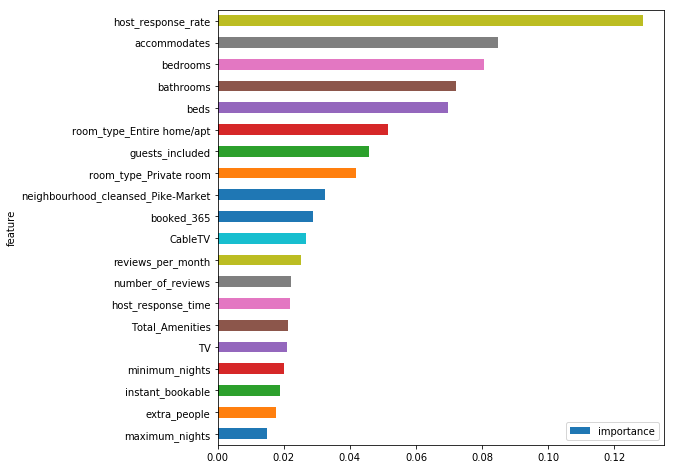

In [32]:
# plot top 20 important features
figsize= (8, 8)
tree_result.sort_values(by='importance',ascending=True)[-20:].plot(x='feature', y='importance', 
                                                                    kind='barh', figsize = figsize)

### Discussion

The figure above shows top 10 important features in descending order. General speaking, host response rate, accommodates, bedrooms, beds and bathrooms are most significant. For dummy variables, room type of "Entire home/apt", "Private room", and amenity of "neighbourhood", "CableTV" add significant values to the listing compared to other categories. 

#### 5.2.3 Interpret the Prediction Result

C:\Users\Choty\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The average R2 score on the test set:  0.7152960586955669
The root-mean-square-error (RMSE) is: $104.98190546102046 


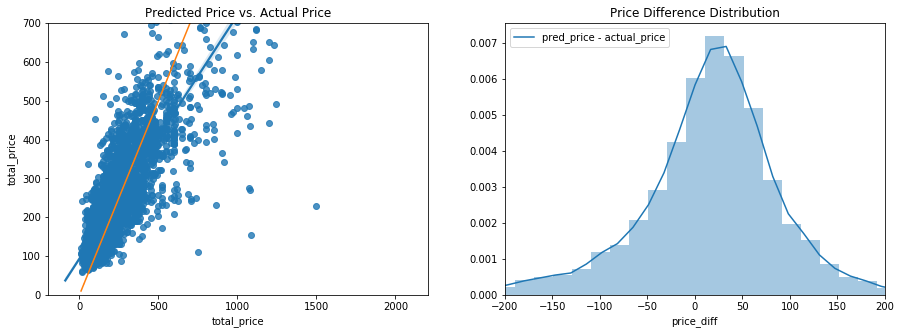

In [33]:
X_test_inv, y_test_inv = inverse_transform(scaler, X_test, y_test)
_, y_pred_inv = inverse_transform(scaler, X_test, pd.DataFrame(y_pred, columns = ['pred_total_price']))
y_test_inv.reset_index(drop = True, inplace = True)
y_pred_inv.reset_index(drop = True, inplace = True)
result = pd.concat([y_test_inv, y_pred_inv], axis = 1)
result = result[~result.total_price.isnull()]
result['price_diff'] = result.pred_total_price - result.total_price
result['pct_diff'] = np.abs(result.pred_total_price - result.total_price)/result.total_price
figsize = (15, 5)
fig = plt.figure(figsize = figsize)
fig.add_subplot(1, 2, 1)
ax = sns.regplot(x= result.total_price, y=result.pred_total_price, fit_reg = True)
#ax.set_xlim(0, 700)
ax.set_ylim(0, 700)
ax.set_title('Predicted Price vs. Actual Price')
ax = sns.lineplot(x=result.total_price, y=result.total_price, data = result, ax = ax)
fig.add_subplot(1, 2, 2)
ax = sns.distplot(result.price_diff, bins = 100, kde_kws = {'label': 'pred_price - actual_price'})
_ = ax.set_xlim(-200, 200)
_ = ax.set_title('Price Difference Distribution')

print('The average R2 score on the test set: ', clf_scores.mean())

print('The root-mean-square-error (RMSE) is: ${} ' \
      .format(np.sqrt(mean_squared_error(result.total_price, result.pred_total_price))))

### Discussion

The scatter plot on the left shows that most data points follow the orange line well, solid line in orange color (y = x). The regression line (blue) deviates from the orange 1:1 line due to outliers near the region: [800, 1000] on the x-axis and [400, 700] on the y-axis. The right panel shows normalized distribution of error, the predicted price subtracted by actual total price. Overall, the prediction accuracy (R-square) is around 72%. The RMSE of the total price (price + cleaning fee) is around \$104.

## 5.3 Book-Rate Model

#### 5.3.1 Build and Train the Model

In [34]:
# select features used for modeling
data = processed_list.copy()
drop_cols = ['reviews_per_month', 'calculated_host_listings_count','review_scores_accuracy',
             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
             'review_scores_value','cancellation_policy']

data.drop(labels = drop_cols, axis = 1, inplace = True)

# drop unwanted amenity dummy variables
amenity_keep_cols = ['WasherDryer', 'Doorman', 'TV', 'AirConditioning', 'FamilyKidFriendly', 'Kitchen',
                     'CableTV', 'Dryer', 'Washer', 'HairDryer'] 
amenity_drop_cols = []
for col in amenity_cols:
    if col not in amenity_keep_cols:
        amenity_drop_cols.append(col)
data.drop(labels = amenity_drop_cols, axis = 1, inplace = True)

## apply feature scaling
scaler = StandardScaler()
data_transformed = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)
data_transformed.head(5)
#X_transformed = data_transformed.drop(labels = ['booked_365'], axis = 1)
#y_transformed = data_transformed[['booked_365']].iloc[:,0]
#X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state = 42)

#criterion = ['mse']
#method = 'RF' 
#n_estimators =  [200, 400]
#max_features = [30, 50, 80] 
#max_depth = [10, 20, 40] 
#min_samples_leaf = [2,4]
#learning_rate = 0.001

#best_clf = GridSearch(X_train, X_test, y_train, y_test, method = method, learning_rate = learning_rate, \
#                         criterion = criterion, n_estimators = n_estimators, \
#                         max_features = max_features, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

C:\Users\Choty\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Choty\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,booked_365,host_days,day_factor,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North End,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Rainier View,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South Delridge,neighbourhood_cleansed_South End,neighbourhood_cleansed_South Lake Union,neighbourhood_cleansed_South Park,neighbourhood_cleansed_Southeast Magnolia,neighbourhood_cleansed_Stevens,neighbourhood_cleansed_Sunset Hill,neighbourhood_cleansed_University District,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_View Ridge,neighbourhood_cleansed_Wallingford,neighbourhood_cle

#### 5.3.2 Evaluate Feature Importance in the Book-Rate Model

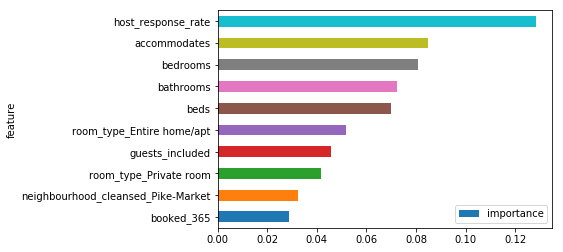

In [35]:
importances = best_clf.feature_importances_ 
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=True)[-10:].plot(x='feature', y='importance', kind='barh')

### Conclusion

The result from above indicate top 10 attributes that AirBnB guests value when choosing the homestay among the listings. In general, they care about the following aspects:

1. host_response_rate; 
2. accommodates;
3. bedrooms, beds and bathrooms;
4. room types: Entire home/apt, Private room;
5. Neighbourhood;

In summary, guests tend to choose the listing with good host response rate and accommodates. In addtion, they also prefer number of bedrooms bedrooms/beds/bathrooms. Mostly prefer Entire home.